In [3]:
# ! pip install plotly-express

In [21]:
# Standard stack
import datetime
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Modeling
import tensorflow as tf
import tensorflow_decision_forests as tfdf
try:
    from wurlitzer import sys_pipes
except:
    from colabtools.googlelog import CaptureLog as sys_pipes

# Scikit-learn packages
from sklearn import metrics
from sklearn.model_selection import train_test_split

## Import helper functions
from ipynb.fs.defs.utils import *

# display
from IPython.core.magic import register_line_magic
from IPython.display import Javascript

In [5]:
KAGGLE_EVAL_METRIC = 'logloss' # string name for loss function in xgboost

In [6]:
TRAIN_PATH = "data/train.csv"
TEST_PATH = "data/test.csv"

In [7]:
TARGET = ["Survived"]

# Load Data

In [107]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

In [108]:
## Bring in Age Predictions

In [109]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

# Pre Process

In [111]:
train = nlp_transforms(train) # name features
train = ticket_transforms(train) # ticket transforms
train.Nickname = np.where(train.Nickname == 'none', 0,1)
train.Junior = np.where(train.Junior == 'none', 0,1)
train.Cabin = train.Cabin.astype(str)
train.Cabin = train.Cabin.apply(lambda x: x[0])
train['family_size'] = train.SibSp + train.Parch + 1

In [ ]:
# Feature Ideas:
#is_mother
#is_father
#solo_father
#solo_mother

In [226]:
train[(train['family_size'] > 1) & (train['SibSp'] == 0)].head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,First Name,Title,Nickname,Last Name,Junior,Middle Names,Ticket Number,Ticket Type,family_size
8,9,1,3,"johnson, mrs. oscar w (elisabeth vilhelmina berg)",female,27.00,0,2,347742,11.1333,...,S,johnson,mrs.,1,oscar,1,w,347742,,3
54,55,0,1,"ostby, mr. engelhart cornelius",male,65.00,0,1,113509,61.9792,...,C,ostby,mr.,0,engelhart,1,cornelius,113509,,2
78,79,1,2,"caldwell, master. alden gates",male,0.83,0,2,248738,29.0000,...,S,caldwell,master.,0,alden,1,gates,248738,,3
97,98,1,1,"greenfield, mr. william bertram",male,23.00,0,1,pc 17759,63.3583,...,C,greenfield,mr.,0,william,1,bertram,17759,pc,2
98,99,1,2,"doling, mrs. john t (ada julia bone)",female,34.00,0,1,231919,23.0000,...,S,doling,mrs.,1,john,1,t,231919,,2
102,103,0,1,"white, mr. richard frasar",male,21.00,0,1,35281,77.2875,...,S,white,mr.,0,richard,1,frasar,35281,,2
118,119,0,1,"baxter, mr. quigg edmond",male,24.00,0,1,pc 17558,247.5208,...,C,baxter,mr.,0,quigg,1,edmond,17558,pc,2
124,125,0,1,"white, mr. percival wayland",male,54.00,0,1,35281,77.2875,...,S,white,mr.,0,percival,1,wayland,35281,,2
136,137,1,1,"newsom, miss. helen monypeny",female,19.00,0,2,11752,26.2833,...,S,newsom,miss.,0,helen,1,monypeny,11752,,3
140,141,0,3,"boulos, mrs. joseph (sultana)",female,NaN,0,2,2678,15.2458,...,C,boulos,mrs.,1,joseph,1,,2678,,3


In [228]:
train[train['First Name'] == 'boulos']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,First Name,Title,Nickname,Last Name,Junior,Middle Names,Ticket Number,Ticket Type,family_size
140,141,0,3,"boulos, mrs. joseph (sultana)",female,NaN,0,2,2678,15.2458,...,C,boulos,mrs.,1,joseph,1,,2678,,3
598,599,0,3,"boulos, mr. hanna",male,NaN,0,0,2664,7.2250,...,C,boulos,mr.,0,hanna,1,,2664,,1
852,853,0,3,"boulos, miss. nourelain",female,9.0,1,1,2678,15.2458,...,C,boulos,miss.,0,nourelain,1,,2678,,3


In [ ]:
# Looks like fare is wrong above? could it be the child + parent fare is combined?
# Looks like tht's a family of 3

In [230]:
train[train['First Name'] == 'collyer']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,First Name,Title,Nickname,Last Name,Junior,Middle Names,Ticket Number,Ticket Type,family_size
237,238,1,2,"collyer, miss. marjorie ""lottie""",female,8.0,0,2,c.a. 31921,26.25,...,S,collyer,miss.,1,marjorie,1,,31921,c.a.,3
637,638,0,2,"collyer, mr. harvey",male,31.0,1,1,c.a. 31921,26.25,...,S,collyer,mr.,0,harvey,1,,31921,c.a.,3
801,802,1,2,"collyer, mrs. harvey (charlotte annie tate)",female,31.0,1,1,c.a. 31921,26.25,...,S,collyer,mrs.,1,harvey,1,,31921,c.a.,3


In [244]:
train[(train['Pclass'] == 1) & (train['Embarked'] == 'C')].head(20).drop(['Last Name','Middle Names','First Name'],  axis=1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Nickname,Junior,Ticket Number,Ticket Type,family_size
1,2,1,1,"cumings, mrs. john bradley (florence briggs th...",female,38.0,1,0,pc 17599,71.2833,C,C,mrs.,1,1,17599,pc,2
30,31,0,1,"uruchurtu, don. manuel e",male,40.0,0,0,pc 17601,27.7208,n,C,don.,0,1,17601,pc,1
31,32,1,1,"spencer, mrs. william augustus (marie eugenie)",female,NaN,1,0,pc 17569,146.5208,B,C,mrs.,1,1,17569,pc,2
34,35,0,1,"meyer, mr. edgar joseph",male,28.0,1,0,pc 17604,82.1708,n,C,mr.,0,1,17604,pc,2
52,53,1,1,"harper, mrs. henry sleeper (myna haxtun)",female,49.0,1,0,pc 17572,76.7292,D,C,mrs.,1,1,17572,pc,2
54,55,0,1,"ostby, mr. engelhart cornelius",male,65.0,0,1,113509,61.9792,B,C,mr.,0,1,113509,,2
64,65,0,1,"stewart, mr. albert a",male,NaN,0,0,pc 17605,27.7208,n,C,mr.,0,1,17605,pc,1
96,97,0,1,"goldschmidt, mr. george b",male,71.0,0,0,pc 17754,34.6542,A,C,mr.,0,1,17754,pc,1
97,98,1,1,"greenfield, mr. william bertram",male,23.0,0,1,pc 17759,63.3583,D,C,mr.,0,1,17759,pc,2
118,119,0,1,"baxter, mr. quigg edmond",male,24.0,0,1,pc 17558,247.5208,B,C,mr.,0,1,17558,pc,2


In [246]:
test[(test['Pclass'] == 1) & (test['Embarked'] == 'C')].head(20)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
20,912,1,"Rothschild, Mr. Martin",male,55.0,1,0,PC 17603,59.4000,NaN,C
23,915,1,"Williams, Mr. Richard Norris II",male,21.0,0,1,PC 17597,61.3792,NaN,C
24,916,1,"Ryerson, Mrs. Arthur Larned (Emily Maria Borie)",female,48.0,1,3,PC 17608,262.3750,B57 B59 B63 B66,C
26,918,1,"Ostby, Miss. Helene Ragnhild",female,22.0,0,1,113509,61.9792,B36,C
34,926,1,"Mock, Mr. Philipp Edmund",male,30.0,1,0,13236,57.7500,C78,C
46,938,1,"Chevre, Mr. Paul Romaine",male,45.0,0,0,PC 17594,29.7000,A9,C
48,940,1,"Bucknell, Mrs. William Robert (Emma Eliza Ward)",female,60.0,0,0,11813,76.2917,D15,C
59,951,1,"Chaudanson, Miss. Victorine",female,36.0,0,0,PC 17608,262.3750,B61,C
64,956,1,"Ryerson, Master. John Borie",male,13.0,2,2,PC 17608,262.3750,B57 B59 B63 B66,C
68,960,1,"Tucker, Mr. Gilbert Milligan Jr",male,31.0,0,0,2543,28.5375,C53,C


# Tensorflow RandomForest

In [114]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'First Name', 'Title',
       'Nickname', 'Last Name', 'Junior', 'Middle Names', 'Ticket Number',
       'Ticket Type', 'family_size'],
      dtype='object')

In [115]:
train.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,First Name,Title,Nickname,Last Name,Junior,Middle Names,Ticket Number,Ticket Type,family_size
0,1,0,3,"braund, mr. owen harris",male,22.0,1,0,a/5 21171,7.25,...,S,braund,mr.,0,owen,1,harris,21171,a/5,2


In [146]:
train.Cabin.unique()

array(['n', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [241]:
columns = ['Survived','Pclass','Sex','Age','Fare','Cabin','Title','Nickname','Junior','Ticket Type','family_size']

## Split and Train

In [242]:
X = train[columns]
y = train[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

# Convert the pandas dataframe into a TensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(X_train, label="Survived")
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(X_test, label="Survived")

# Train the model
model_1 = tfdf.keras.RandomForestModel()
model_1.fit(train_ds)

#Evaluate
# metric logsloss: BinaryCrossentropy
model_1.compile(metrics=["accuracy"])

#with sys_pipes():
model_1.fit(x=train_ds)

evaluation = model_1.evaluate(test_ds, return_dict=True)
print(evaluation)

3/3 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.8268
{'loss': 0.0, 'accuracy': 0.826815664768219}


In [152]:
# 0.8444444537162781 = best

In [153]:
# Interpreting
tfdf.model_plotter.plot_model_in_colab(model_1, tree_idx=0)

In [154]:
model_1.summary()

Model: "random_forest_model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (9):
	Age
	Cabin
	Fare
	Junior
	Nickname
	Pclass
	Sex
	Title
	family_size

No weights

Variable Importance: NUM_NODES:
    1.        "Fare" 7716.000000 ################
    2.         "Age" 6681.000000 #############
    3. "family_size" 1569.000000 ##
    4.       "Cabin" 1176.000000 ##
    5.      "Pclass" 815.000000 #
    6.       "Title" 758.000000 #
    7.    "Nickname" 475.000000 
    8.         "Sex" 188.000000 

Variable Importance: NUM_AS_ROOT:
    1.    "Title" 154.000000 ################
    2.      "Sex" 95.000000 #########
    3.     "Fare" 19.000000 #
    4. "Nickname" 14.000000 
    5.    "Cabin" 13.000000 
    6

In [155]:
model_1.make_inspector().features()

["Age" (1; #0),
 "Cabin" (4; #1),
 "Fare" (1; #2),
 "Junior" (1; #3),
 "Nickname" (1; #4),
 "Pclass" (1; #5),
 "Sex" (4; #6),
 "Title" (4; #7),
 "family_size" (1; #8)]

In [156]:
## Parameter Tuning

In [158]:
model_1.make_inspector().variable_importances()

{'NUM_AS_ROOT': [("Title" (4; #7), 154.0),
  ("Sex" (4; #6), 95.0),
  ("Fare" (1; #2), 19.0),
  ("Nickname" (1; #4), 14.0),
  ("Cabin" (4; #1), 13.0),
  ("Pclass" (1; #5), 5.0)]}

In [112]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel]

In [159]:
model_1.make_inspector().evaluation()

Evaluation(num_examples=712, accuracy=0.824438202247191, loss=0.761041834384721, rmse=None, ndcg=None, aucs=None)

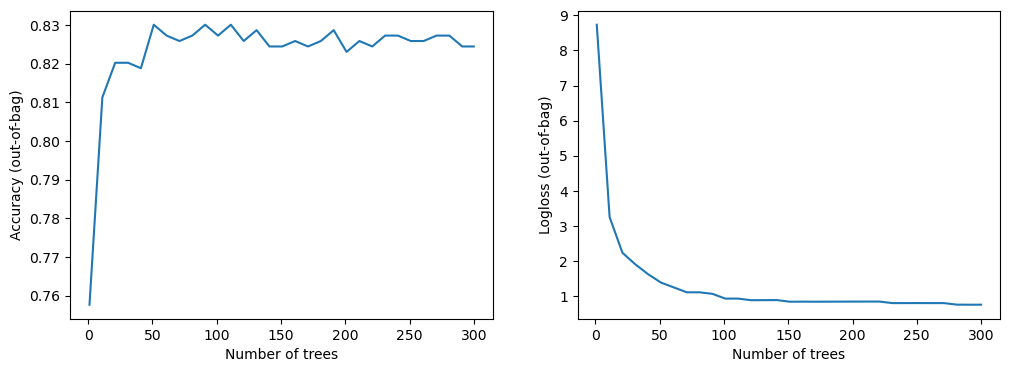

In [160]:
import matplotlib.pyplot as plt

logs = model_1.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

In [161]:
# This cell start TensorBoard that can be slow.
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Google internal version
# %load_ext google3.learning.brain.tensorboard.notebook.extension

In [180]:
# Clear existing results (if any)
rm -fr "/tmp/tensorboard_logs"

SyntaxError: invalid syntax (<ipython-input-180-070c4d4e4a96>, line 2)

In [181]:
# Export the meta-data to tensorboard.
model_6.make_inspector().export_to_tensorboard("/tmp/tensorboard_logs")

In [184]:
# Start a tensorboard instance.
%tensorboard --logdir "/tmp/tensorboard_logs"

Reusing TensorBoard on port 6006 (pid 15517), started 0:03:33 ago. (Use '!kill 15517' to kill it.)

In [113]:
# ? tfdf.keras.GradientBoostedTreesModel

# Hyper-parameters

In [206]:
# A classical but slighly more complex model.
model_6 = tfdf.keras.GradientBoostedTreesModel(
    num_trees=500, growing_strategy="BEST_FIRST_GLOBAL", max_depth=10)
model_6.compile( metrics=["accuracy"])
model_6.fit(x=train_ds)
print(model_6.evaluate(test_ds, return_dict=True))

3/3 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.8659
{'loss': 0.0, 'accuracy': 0.8659217953681946}


In [207]:
model_6.make_inspector().variable_importances()

{'NUM_AS_ROOT': [("Title" (4; #7), 13.0),
  ("Pclass" (1; #5), 7.0),
  ("Sex" (4; #6), 4.0),
  ("Fare" (1; #2), 2.0),
  ("Nickname" (1; #4), 1.0)]}

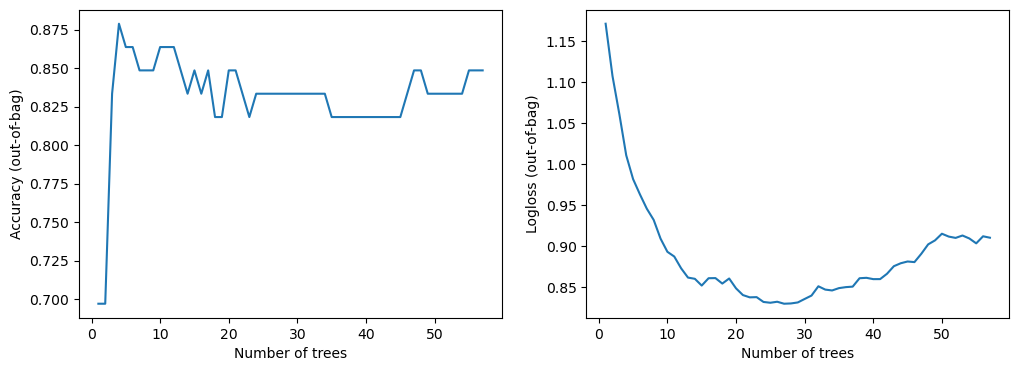

In [208]:
import matplotlib.pyplot as plt

logs = model_6.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

In [205]:
# A classical but slighly more complex model.
model_6 = tfdf.keras.GradientBoostedTreesModel(
    num_trees=100, growing_strategy="BEST_FIRST_GLOBAL", max_depth=3)
model_6.compile( metrics=["accuracy"])
model_6.fit(x=train_ds)
print(model_6.evaluate(test_ds, return_dict=True))

3/3 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.8436
{'loss': 0.0, 'accuracy': 0.8435754179954529}


In [166]:
# A more complex, but possibly, more accurate model.
model_7 = tfdf.keras.GradientBoostedTreesModel(
    num_trees=500,
    growing_strategy="BEST_FIRST_GLOBAL",
    max_depth=8,
    split_axis="SPARSE_OBLIQUE",
    categorical_algorithm="RANDOM",
    )
model_7.compile( metrics=["accuracy"])
model_7.fit(x=train_ds, validation_data=test_ds)
print(model_7.evaluate(test_ds, return_dict=True))

3/3 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.8156
{'loss': 0.0, 'accuracy': 0.8156424760818481}


In [169]:
# A good template of hyper-parameters.
model_8 = tfdf.keras.GradientBoostedTreesModel(hyperparameter_template="benchmark_rank1")
model_8.compile( metrics=["accuracy"])
model_8.fit(x=train_ds, validation_data=test_ds)
print(model_8.evaluate(test_ds, return_dict=True))

3/3 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.8156
{'loss': 0.0, 'accuracy': 0.8156424760818481}


# Pre Processing
With kera to embed  processing into model